In [12]:
# !pip install segmentation-models-pytorch
# !pip install -U git+https://github.com/albumentations-team/albumentations
# !pip install --upgrade opencv-contrib-python

In [16]:
import sys
sys.path.append('/media/amin/01D8E46A7A48FE60/projects/Instance-Segmentation-on-ADE20K-dataset/')

In [17]:
import torch 
import cv2

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

In [58]:
TRAIN_TXT = '/media/amin/01D8E46A7A48FE60/projects/Instance-Segmentation-on-ADE20K-dataset/dataset/images/training.txt'
VALID_TXT = '/media/amin/01D8E46A7A48FE60/projects/Instance-Segmentation-on-ADE20K-dataset/dataset/images/validation.txt'
DATA_DIR = '/media/amin/01D8E46A7A48FE60/projects/'
IMAGES_PATH = '/media/amin/01D8E46A7A48FE60/projects/Instance-Segmentation-on-ADE20K-dataset/dataset/images/'
ANNOTITIONS_PATH = '/media/amin/01D8E46A7A48FE60/projects/Instance-Segmentation-on-ADE20K-dataset/dataset/annotations_instance/'

DEVICE = 'cuda'
EPOCHS = 25
LR = 0.003
IMAGE_SIZE = 320
BATCH_SIZE = 16

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [59]:
train_df = pd.read_fwf(TRAIN_TXT,header=None)
train_df.columns = ['images']
train_df.head()

,images
0,training/ADE_train_00000001.jpg
1,training/ADE_train_00000002.jpg
2,training/ADE_train_00000003.jpg
3,training/ADE_train_00000004.jpg
4,training/ADE_train_00000005.jpg


In [60]:
valid_df = pd.read_fwf(VALID_TXT,header=None)
valid_df.columns = ['images']
valid_df.head()

,images
0,validation/ADE_val_00000001.jpg
1,validation/ADE_val_00000002.jpg
2,validation/ADE_val_00000003.jpg
3,validation/ADE_val_00000004.jpg
4,validation/ADE_val_00000005.jpg


In [61]:
train_masks = []
valid_masks = []
for i in range(len(train_df)):
    train_masks.append(train_df.iloc[i][0].replace('jpg' , 'png'))
for i in range(len(valid_df)):
    valid_masks.append(valid_df.iloc[i][0].replace('jpg' , 'png'))

In [62]:
train_df['masks'] = train_masks
valid_df['masks'] = valid_masks
train_df.head()

,images,masks
0,training/ADE_train_00000001.jpg,training/ADE_train_00000001.png
1,training/ADE_train_00000002.jpg,training/ADE_train_00000002.png
2,training/ADE_train_00000003.jpg,training/ADE_train_00000003.png
3,training/ADE_train_00000004.jpg,training/ADE_train_00000004.png
4,training/ADE_train_00000005.jpg,training/ADE_train_00000005.png


In [63]:
train_df['images'] = IMAGES_PATH + train_df['images'].astype(str)
train_df['masks'] = ANNOTITIONS_PATH + train_df['masks'].astype(str)
train_df.head()

,images,masks
0,/media/amin/01D8E46A7A48FE60/projects/Instance...,/media/amin/01D8E46A7A48FE60/projects/Instance...
1,/media/amin/01D8E46A7A48FE60/projects/Instance...,/media/amin/01D8E46A7A48FE60/projects/Instance...
2,/media/amin/01D8E46A7A48FE60/projects/Instance...,/media/amin/01D8E46A7A48FE60/projects/Instance...
3,/media/amin/01D8E46A7A48FE60/projects/Instance...,/media/amin/01D8E46A7A48FE60/projects/Instance...
4,/media/amin/01D8E46A7A48FE60/projects/Instance...,/media/amin/01D8E46A7A48FE60/projects/Instance...


In [64]:
valid_df['images'] = IMAGES_PATH + valid_df['images'].astype(str)
valid_df['masks'] = ANNOTITIONS_PATH + valid_df['masks'].astype(str)
valid_df.head()

,images,masks
0,/media/amin/01D8E46A7A48FE60/projects/Instance...,/media/amin/01D8E46A7A48FE60/projects/Instance...
1,/media/amin/01D8E46A7A48FE60/projects/Instance...,/media/amin/01D8E46A7A48FE60/projects/Instance...
2,/media/amin/01D8E46A7A48FE60/projects/Instance...,/media/amin/01D8E46A7A48FE60/projects/Instance...
3,/media/amin/01D8E46A7A48FE60/projects/Instance...,/media/amin/01D8E46A7A48FE60/projects/Instance...
4,/media/amin/01D8E46A7A48FE60/projects/Instance...,/media/amin/01D8E46A7A48FE60/projects/Instance...


In [65]:
train_df.iloc[0].images

'/media/amin/01D8E46A7A48FE60/projects/Instance-Segmentation-on-ADE20K-dataset/dataset/images/training/ADE_train_00000001.jpg'

In [260]:
row = train_df.iloc[800]

image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE) / 255.0

In [261]:
print(image.shape)
print(mask.shape)

(512, 768, 3)
(512, 768)


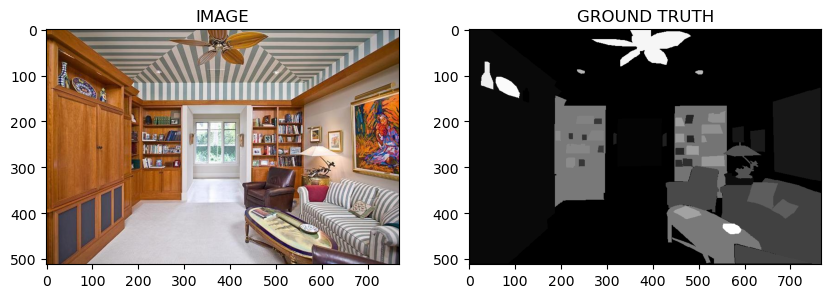

In [262]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [263]:
import albumentations as A

In [264]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE, IMAGE_SIZE),
      A.HorizontalFlip(p = 0.5),
      A.VerticalFlip(p = 0.5),
  ])

def get_valid_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE, IMAGE_SIZE),
  ])

In [265]:
from torch.utils.data import Dataset

In [282]:
class SegmentationDataset(Dataset):

  def __init__(self,df,augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)
  
  def __getitem__(self,idx):

    row = self.df.iloc[idx]

    image_path = row.images
    mask_path = row.masks
    

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) #(h, w, c)
    mask = np.expand_dims(mask, axis=-1)
    
    if self.augmentations:
        data = self.augmentations(image = image, mask = mask)
        image = data['image']
        mask = data['mask']

    # (h, w, c) -> (c, h, w)
    image = np.transpose(image,(2,0,1)).astype(np.float32)
    mask = np.transpose(mask,(2,0,1)).astype(np.float32)

    image = torch.Tensor(image) / 255.0
    mask = torch.Tensor(mask) / 255.0
    #mask[mask>0] = 1

    return image,mask

In [284]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [285]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 20210
Size of Validset : 2000


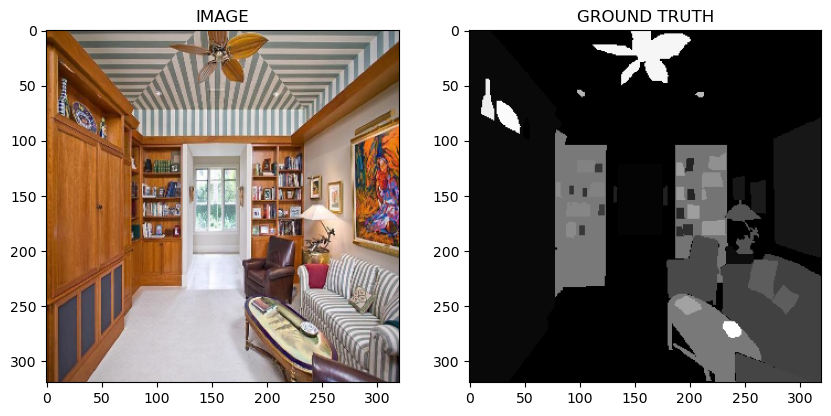

In [286]:
idx = 800

image, mask = trainset[idx]
helper.show_image(image, mask)


In [287]:
from torch.utils.data import DataLoader

In [288]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)

In [289]:
print(f"total number of batches in trainloader : {len(trainloader)}")
print(f"total number of batches in validloader : {len(validloader)}")

total number of batches in trainloader : 1264
total number of batches in validloader : 125


In [290]:
for image, mask in trainloader:
  break

print(f"One batch image shape : {image.shape}")
print(f"One batch mask shape : {mask.shape}")

One batch image shape : torch.Size([16, 3, 320, 320])
One batch mask shape : torch.Size([16, 1, 320, 320])


In [291]:
from torch  import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [292]:
class SegmentationModel(nn.Module):

  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.arc = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights = WEIGHTS,
        in_channels = 3,
        classes = 1,
        activation = None,
    )

  def forward(self, images, masks = None):

    logits = self.arc(images)

    if masks != None:
      loss1 = DiceLoss(mode = 'binary')(logits,masks)
      loss2 = nn.BCEWithLogitsLoss()(logits,masks)
      return logits, loss1 + loss2

    return logits

In [293]:
model = SegmentationModel()
model.to(DEVICE)

Downloading: "https://github.com/huggingface/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0-0af12548.pth" to /home/amin/.cache/torch/hub/checkpoints/tf_efficientnet_b0-0af12548.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
           

In [294]:
def train_fn(data_loader, model, optimizer):

  model.train()
  total_loss = 0.0

  for images ,masks in tqdm(data_loader):

    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(data_loader)



In [295]:
def eval_fn(data_loader, model):

  model.eval()
  total_loss = 0.0

  with torch.no_grad():
    for images ,masks in tqdm(data_loader):

      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      logits, loss = model(images, masks)

      total_loss += loss.item()

  return total_loss / len(data_loader)



In [296]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [297]:
best_val_loss = np.Inf

for i in range(EPOCHS):

  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model)

  if valid_loss < best_val_loss:
    torch.save(model.state_dict(),"best_model.pt")
    print("Saved-Model")
    best_val_loss = valid_loss

  print(f"Epoch : {i+1} Train_loss : {train_loss} Valid_loss : {valid_loss}")

  0%|          | 0/1264 [00:03<?, ?it/s]


RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 3.95 GiB total capacity; 3.27 GiB already allocated; 3.81 MiB free; 3.38 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
idx = 2

model.load_state_dict(torch.load('/media/amin/01D8E46A7A48FE60/projects/Instance-Segmentation-on-ADE20K-dataset/best_model.pt'))


image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0)) # (c, h, w) -> (1, c, h, w)
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5)* 1.0